# Predicting Future Sales

My score of 0.96224 RMSE achieved rank 2416 of 6284 on Kaggle. However, limitations on how much of the data I could run on my laptop means that it is highly likely that an improvement on this score could be achieved and is something I could come back to at a later date. 

In [3]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import statsmodels
import matplotlib.pyplot as plt

%matplotlib inline

#Modelling
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV, RandomizedSearchCV, StratifiedKFold, KFold, RepeatedKFold, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression,  Ridge, RidgeCV
from sklearn.kernel_ridge import KernelRidge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler, LabelEncoder
from sklearn.svm import NuSVC, SVC
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix, plot_confusion_matrix, f1_score
from scipy.signal import hilbert, hann, convolve
from scipy import stats
import xgboost as xgb

pd.options.display.precision = 15

import time
from datetime import datetime, date
import json
import ast
from math import ceil
from itertools import product
import holidays

import gc
import warnings
warnings.filterwarnings("ignore")

from IPython.display import HTML

In [3]:
train = pd.read_csv('data/sales_train.csv')
test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
items = pd.read_csv('data/items_en.csv')
item_cats = pd.read_csv('data/item_categories_en.csv')
shops = pd.read_csv('data/shops_en.csv')

The process of this problem is to extract features from the files relating to items, cateogories and shops before including lagged and mean encoded sales features. 

### 0. Including revenue as a feature

The price of an item could have an impact on the quanity of items sold. Using the previous monthly revenue for a shop/item could be a good feature and should be included.

In [4]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

### 1. Outlier treatment

In [4]:
train.describe()

,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
count,2.935849000000000e+06,2.935849000000000e+06,2.935849000000000e+06,2.935849000000000e+06,2.935849000000000e+06,2.935849000000000e+06
mean,1.456991146343017e+01,3.300172829052175e+01,1.019722705697738e+04,8.908532326979881e+02,1.242640885140891e+00,1.157732003440867e+03
std,9.422987708752936e+00,1.622697304830942e+01,6.324297353888805e+03,1.729799630712986e+03,2.618834430899203e+00,5.683603656618650e+03
min,0.000000000000000e+00,0.000000000000000e+00,0.000000000000000e+00,-1.000000000000000e+00,-2.200000000000000e+01,-6.897000000000000e+04
25%,7.000000000000000e+00,2.200000000000000e+01,4.476000000000000e+03,2.490000000000000e+02,1.000000000000000e+00,2.490000000000000e+02
50%,1.400000000000000e+01,3.100000000000000e+01,9.343000000000000e+03,3.990000000000000e+02,1.000000000000000e+00,4.490000000000000e+02
75%,2.300000000000000e+01,4.700000000000000e+01,1.568400000000000e+04,9.990000000000000e+02,1.000000000000000e+00,1.078200000000000e+03
max,3.300000000000000e+01,5.900000000000000e+01,2.216900000000000e+04,3.079800000000000e+05,2.169000000000000e+03,1.829990000001300e+06


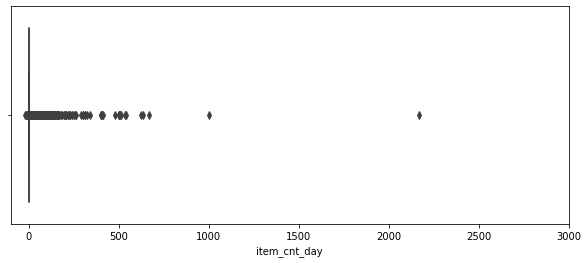

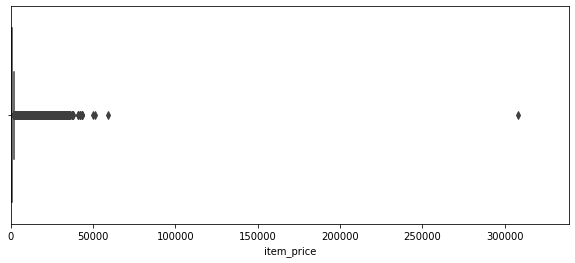

In [5]:
plt.figure(figsize=(10,4))
plt.xlim(-100, 3000)
sns.boxplot(x=train.item_cnt_day)

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1)
sns.boxplot(x=train.item_price)

The 2 plots show there are 2 days with very high item counts, which may be correct but for this analysis the 2 points will be removed. THe item price outlier looks strange and will be removed.

In [6]:
train = train[train.item_price<100000]
train = train[train.item_cnt_day<1001]

There is one item with price below zero (as seen in the min value from describe). The median for that shop and item shall be chosen to fill in this value.

In [7]:
train[train.item_price < 0]

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day,revenue
484683,15.05.2013,4,32,2973,-1.0,1.0,-1.0


In [8]:
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
train.loc[train.item_price<0, 'item_price'] = median

#### Duplicate values in shops

In [10]:
shops.sort_values(by = ['shop_name'], ascending = True)

,shop_name,shop_id
0,"! Yakutsk Ordzhonikidze, 56 Franc",0
1,"! Yakutsk TC ""Central"" Franc",1
2,"Adygea TC ""Mega""",2
3,"Balashikha TRC ""October-Kinomir""",3
56,"Czechs SEC ""Carnival""",56
55,Digital storage 1C-line,55
9,Itinerant trade,9
15,"Kaluga SEC ""XXI Century""",15
13,"Kazan shopping center ""Bahetle""",13
14,"Kazan shopping mall of ""Parkhouse"" II of",14


It appears the shop name for shop_id 0 and 1 both have an exclamation mark before them and in truth are the same shop as 57 and 58 respectively. 10 and 11 are also the same but have 1 character different.

In [11]:
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57

train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58

train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

### 2. Adding features (Cities, Item Types & Subtypes)

#### Cities of shops and creating ids

City names are contained in the shop name. This can be stripped out and a feature formed with it. However there are a few shop names that need renamed to allow this city to be stripped out.

In [12]:
shops.loc[shops.shop_name == '! Yakutsk Ordzhonikidze, 56 Franc', 'shop_name'] = 'Yakutsk Ordzhonikidze, 56 Franc'
shops.loc[shops.shop_name == '! Yakutsk TC "Central" Franc', 'shop_name'] = 'Yakutsk TC "Central" Franc'
shops.loc[shops.shop_name == 'Shop Online Emergencies', 'shop_name'] = 'Shop_Online Emergencies'
shops.loc[shops.shop_name == 'St. Petersburg TK "Nevsky Center"', 'shop_name'] = 'St.Petersburg TK "Nevsky Center"'
shops.loc[shops.shop_name == 'St. Petersburg TK "Sennaya"', 'shop_name'] = 'St.Petersburg TK "Sennaya"" Franc'

In [13]:
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0])
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
shops = shops[['shop_id','city_code']]

#### Creating ids for item and item subtype

In [14]:
item_cats['split'] = item_cats['item_category_name'].str.split('-')
item_cats['type'] = item_cats['split'].map(lambda x: x[0].strip())
item_cats['type_code'] = LabelEncoder().fit_transform(item_cats['type'])
# if subtype is nan then type
item_cats['subtype'] = item_cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())
item_cats['subtype_code'] = LabelEncoder().fit_transform(item_cats['subtype'])
item_cats = item_cats[['item_category_id','type_code', 'subtype_code']]
items.drop(['item_name'], axis=1, inplace=True)

In [15]:
ts = time.time()
grid = []
cols = ['date_block_num','shop_id','item_id']
for i in range(34):
    sales = train[train.date_block_num==i]
    grid.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
    
grid = pd.DataFrame(np.vstack(grid), columns=cols)
grid['date_block_num'] = grid['date_block_num'].astype(np.int8)
grid['shop_id'] = grid['shop_id'].astype(np.int8)
grid['item_id'] = grid['item_id'].astype(np.int16)
grid.sort_values(cols,inplace=True)
time.time() - ts

9.865304946899414

#### Joining monthly sales onto monthly grid of shop/item

In [16]:
train_grp = train.groupby(['shop_id', 'item_id', 'date_block_num']).agg({'item_cnt_day': ['sum']})
train_grp.columns=['item_cnt_month']
train_grp.reset_index(inplace=True)

In [17]:
ts = time.time()
grid = pd.merge(grid, train_grp, on=['shop_id', 'item_id', 'date_block_num'], how='left')
grid['item_cnt_month'] = (grid['item_cnt_month']
                                .fillna(0)
                                .clip(0,20) # NB clip target here
                                .astype(np.float16))
time.time() - ts

14.90252161026001

### 3. Adding features (Month and Bank Holidays)

The actual month of sale could have a significant impact on the sales

In [18]:
train['month'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%m'))
train['year'] = train.date.apply(lambda x: datetime.strptime(x, '%d.%m.%Y').strftime('%Y'))
train_month = train[['date_block_num', 'month']]
train_month.drop_duplicates(inplace= True)

#### Add bank holiday information

January in particular has many public holidays in Russia. It would be interesting to look into whether this has any impact on sales.

In [19]:
hol_dates = []
for date in holidays.Russia(years = [2013,2014,2015]).items():
    hol_dates.append(str(date[0]))

Change to group by the hol months to month and count. Then join this information onto train set by month and year. 

In [20]:
hol_dates = pd.DataFrame(hol_dates)

In [21]:
hol_dates['month']=0
hol_dates['year']=0
hol_dates.rename(columns={0:'date'}, inplace = True)

hol_dates['month'] = hol_dates.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%m'))
hol_dates['year'] = hol_dates.date.apply(lambda x: datetime.strptime(x, '%Y-%m-%d').strftime('%Y'))

hol_dates = hol_dates.groupby(['month', 'year']).count().reset_index()
hol_dates.rename(columns = {'date':'hol_count'}, inplace=True)

This grid has created a combination of all shop and item combinations (regardless of it they were sold by that shop). 

In [25]:
train = pd.merge(train, hol_dates, on=['month', 'year'], how='left')

train_hol = train[['date_block_num', 'hol_count']]
train_hol.drop_duplicates(inplace= True)

train_hol['hol_count'] = train_hol.hol_count.fillna(0)

grid = pd.merge(grid, train_month, on=['date_block_num'], how='left')
grid = pd.merge(grid, train_hol, on=['date_block_num'], how='left')

### 4. Join the test set

From some analysis of the test set, there are 42 shops, all with 5100 items. Which equates to the 214200 rows of data in the test set. The train set only contains sales or items that were returned so it needs to include items that did not generate any sale. This can be done by looking at unique pairs of shop_ids and item_ids per month. 

In [31]:
test['date_block_num'] = 34
test['month'] = 11
test['hol_count'] = 1

test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [33]:
ts = time.time()
grid = pd.concat([grid, test], ignore_index=True, sort=False, keys=['date_block_num', 'shop_id', 'item_id', 'month', 'hol_count'])
grid.fillna(0, inplace=True) # 34 month
time.time() - ts

0.9922201633453369

In [34]:
pd.concat([grid, test], ignore_index=True, sort=False, keys=['date_block_num', 'shop_id', 'item_id'])
grid.drop(columns='ID', inplace=True)

### 5. Join shop, city and item information

The features created in (2) are now joined onto the grid created.

In [38]:
ts = time.time()
grid = pd.merge(grid, shops, on=['shop_id'], how='left')
grid = pd.merge(grid, items, on=['item_id'], how='left')
grid = pd.merge(grid, item_cats, on=['item_category_id'], how='left')
grid['city_code'] = grid['city_code'].astype(np.int8)
grid['item_category_id'] = grid['item_category_id'].astype(np.int8)
grid['type_code'] = grid['type_code'].astype(np.int8)
grid['subtype_code'] = grid['subtype_code'].astype(np.int8)
time.time() - ts

6.146758556365967

### Add price to grid

In [40]:
grouped_price = train.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_price': ['mean']}).reset_index()
grid = pd.merge(grid, grouped_price, how='left', on=['date_block_num', 'shop_id', 'item_id'])
grid.rename(columns={'(item_price, mean)':'item_price'},inplace=True)
grid.rename(columns={('item_price', 'mean'): 'item_price'}, inplace=True)
grid['item_price'] = grid['item_price'].fillna(-1)

### 6. Lagged variables and mean encoding

The majority of the features that will help to predict future sales will be historical sales history. This will done through:
- Lagged features for sales, item price or revenue
- Mean encoded sales relating to a combination of features such as shop, item, item cateogry, item type etc.

#### Function for making lags shop & specific variable

In [6]:
def lags(df, lags, col):
    temp = df[['date_block_num', 'shop_id', 'item_id', col]]
    for i in lags:
        lagged = temp.copy()
        lagged['date_block_num'] += i
        lagged.columns = ['date_block_num', 'shop_id', 'item_id', col + '_prev_' + str(i)]
        df = pd.merge(df, lagged, on=['date_block_num', 'shop_id', 'item_id'], how='left')
    return df

In [7]:
def lag_shop_type(df, lags, col):
    temp = df[['date_block_num', 'shop_id', 'type_code', col]]
    for i in lags:
        lagged = temp.copy()
        lagged['date_block_num'] += i
        lagged.columns = ['date_block_num', 'shop_id', 'type_code', col + '_prev_' + str(i)]
        df = pd.merge(df, lagged, on=['date_block_num', 'shop_id', 'type_code'], how='left')
    return df

In [8]:
def lag_shop_subtype(df, lags, col):
    temp = df[['date_block_num', 'shop_id', 'subtype_code', col]]
    for i in lags:
        lagged = temp.copy()
        lagged['date_block_num'] += i
        lagged.columns = ['date_block_num', 'shop_id', 'subtype_code', col + '_prev_' + str(i)]
        df = pd.merge(df, lagged, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
    return df

#### Functions for making specific variable lag

In [9]:
def lag_shop(df, lags, col):
    temp = df[['date_block_num', 'shop_id', col]]
    for i in lags:
        lagged = temp.copy()
        lagged['date_block_num'] += i
        lagged.columns = ['date_block_num', 'shop_id', 'item_id', col + '_prev_' + str(i)]
        df = pd.merge(df, lagged, on=['date_block_num', 'shop_id'], how='left')
    return df

In [10]:
def lag_item(df, lags, col):
    temp = df[['date_block_num', 'item_id', col]]
    for i in lags:
        lagged = temp.copy()
        lagged['date_block_num'] += i
        lagged.columns = ['date_block_num', 'item_id', col + '_prev_' + str(i)]
        df = pd.merge(df, lagged, on=['date_block_num', 'item_id'], how='left')
    return df

In [11]:
def lag_type(df, lags, col):
    temp = df[['date_block_num', 'type_code', col]]
    for i in lags:
        lagged = temp.copy()
        lagged['date_block_num'] += i
        lagged.columns = ['date_block_num', 'type_code', col + '_prev_' + str(i)]
        df = pd.merge(df, lagged, on=['date_block_num', 'type_code'], how='left')
    return df

In [12]:
def lag_Subtype(df, lags, col):
    temp = df[['date_block_num', 'subtype_code', col]]
    for i in lags:
        lagged = temp.copy()
        lagged['date_block_num'] += i
        lagged.columns = ['date_block_num', 'subtype_code', col + '_prev_' + str(i)]
        df = pd.merge(df, lagged, on=['date_block_num', 'subtype_code'], how='left')
    return df

### a. 1,2,6,12 months lagged sales.

In [13]:
grid = lags(grid, [1,2,6,12], col='item_cnt_month')

### b. 1,2,6,12 months lagged item price

In [14]:
grid = lags(grid, [1,2,6,12], col='item_price')

#### Last month shop revenue

In [15]:
grid['revenue'] =grid['item_price'] * grid['item_cnt_month']

### c. 1,2,6,12 months lagged revenue

In [16]:
grid = lags(grid, [1,2,6,12], col='revenue')

### Mean encoded item and shop price

By calculating the mean item price for lagged months by shop and item id can be used to understand the difference between the price a shop charges for an item and what the mean was for that month. Shop that sell under the mean in theory should be seeing greater sales than those that don't? 
The same logic is used for the shop price. Are there certain items that are a greater distance away from the shop's item mean price. If so those items may or may not sell so frequently.

### d. 1,2,6,12 months item price

In [17]:
ts = time.time()
group = grid.groupby(['date_block_num', 'item_id']).agg({'item_price': ['mean']})
group.columns = [ 'date_item_avg_item_price' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num','item_id'], how='left')
grid['date_item_avg_item_price'] = grid['date_item_avg_item_price'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_item_avg_item_price')
grid.drop(['date_item_avg_item_price'], axis=1, inplace=True)
time.time() - ts

48.39122128486633

### e. 1,2,6,12 months shop price

In [18]:
ts = time.time()
group = grid.groupby(['date_block_num', 'shop_id']).agg({'item_price': ['mean']})
group.columns = [ 'date_shop_avg_item_price' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num','shop_id'], how='left')
grid['date_shop_avg_item_price'] = grid['date_shop_avg_item_price'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_shop_avg_item_price')
grid.drop(['date_shop_avg_item_price'], axis=1, inplace=True)
time.time() - ts

44.14887857437134

In [19]:
grid = grid.fillna(0)

Look at the difference between the mean item prices against each item and shop

In [21]:
grid['item_price_item_diff_1'] = grid['item_price_prev_1'] - grid['date_item_avg_item_price_prev_1']
grid['item_price_item_diff_2'] = grid['item_price_prev_2'] - grid['date_item_avg_item_price_prev_2']
grid['item_price_item_diff_6'] = grid['item_price_prev_6'] - grid['date_item_avg_item_price_prev_6']
grid['item_price_item_diff_12'] = grid['item_price_prev_12'] - grid['date_item_avg_item_price_prev_12']

grid['item_price_shop_diff_1'] = grid['item_price_prev_1'] - grid['date_shop_avg_item_price_prev_1']
grid['item_price_shop_diff_2'] = grid['item_price_prev_2'] - grid['date_shop_avg_item_price_prev_2']
grid['item_price_shop_diff_6'] = grid['item_price_prev_6'] - grid['date_shop_avg_item_price_prev_6']
grid['item_price_shop_diff_12'] = grid['item_price_prev_12'] - grid['date_shop_avg_item_price_prev_12']

## Target (Item Sales) Mean Encoding

### f. 1,2,6,12 month mean encoded sales

In [22]:
ts = time.time()
group = grid.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num'], how='left')
grid['date_avg_item_cnt'] = grid['date_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_avg_item_cnt')
grid.drop(['date_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

69.70149111747742

### g. 1,2,6,12 month shop/item mean encoded sales

In [23]:
ts = time.time()
group = grid.groupby(['date_block_num', 'shop_id', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_item_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num', 'shop_id','item_id'], how='left')
grid['date_shop_item_avg_item_cnt'] = grid['date_shop_item_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_shop_item_avg_item_cnt')
grid.drop(['date_shop_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

75.65330862998962

### h. 1,2,6,12 month item mean encoded sales

In [24]:
ts = time.time()
group = grid.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num','item_id'], how='left')
grid['date_item_avg_item_cnt'] = grid['date_item_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,6,12], 'date_item_avg_item_cnt')
grid.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

68.71035647392273

### i. 1,2,6,12 month mean encoded sales

In [25]:
ts = time.time()
group = grid.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num','shop_id'], how='left')
grid['date_shop_avg_item_cnt'] = grid['date_shop_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_shop_avg_item_cnt')
grid.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

69.6714780330658

### j. 1,2,6,12 month item category mean encoded sales

In [26]:
ts = time.time()
group = grid.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num','item_category_id'], how='left')
grid['date_cat_avg_item_cnt'] = grid['date_cat_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_cat_avg_item_cnt')
grid.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

82.00425457954407

### k. 1,2,6,12 month shop &item category mean encoded sales

In [27]:
ts = time.time()
group = grid.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
grid['date_shop_cat_avg_item_cnt'] = grid['date_shop_cat_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_shop_cat_avg_item_cnt')
grid.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

82.66957426071167

### l. 1,2,6,12 month shop & item type mean encoded sales

In [28]:
ts = time.time()
group = grid.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
grid['date_shop_type_avg_item_cnt'] = grid['date_shop_type_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_shop_type_avg_item_cnt')
grid.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

78.89294576644897

### m. 1,2,6,12 month shop & item sub type mean encoded sales

In [29]:
ts = time.time()
group = grid.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
grid['date_shop_subtype_avg_item_cnt'] = grid['date_shop_subtype_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_shop_subtype_avg_item_cnt')
grid.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

85.96769547462463

### n. 1,2,6,12 month city mean encoded sales

In [30]:
ts = time.time()
group = grid.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num', 'city_code'], how='left')
grid['date_city_avg_item_cnt'] = grid['date_city_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_city_avg_item_cnt')
grid.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

86.19837760925293

### o. 1,2,6,12 month item & city mean encoded sales

In [31]:
ts = time.time()
group = grid.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
grid['date_item_city_avg_item_cnt'] = grid['date_item_city_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_item_city_avg_item_cnt')
grid.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

101.65621542930603

### p. 1,2,6,12 month item type mean encoded sales

In [32]:
ts = time.time()
group = grid.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num', 'type_code'], how='left')
grid['date_type_avg_item_cnt'] = grid['date_type_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_type_avg_item_cnt')
grid.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

101.56162285804749

### q. 1,2,6,12 month item sub type mean encoded sales

In [33]:
ts = time.time()
group = grid.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

grid = pd.merge(grid, group, on=['date_block_num', 'subtype_code'], how='left')
grid['date_subtype_avg_item_cnt'] = grid['date_subtype_avg_item_cnt'].astype(np.float16)
grid = lags(grid, [1,2,6,12], 'date_subtype_avg_item_cnt')
grid.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

94.84383964538574

### 7. Days in a month

The target variable for this problem is the sale per month. Therefore months with a greater number of days should see more sales than those with less.

In [35]:
day_month = pd.DataFrame({'month':[1,2,3,4,5,6,7,8,9,10,11,12], 'days':[31,28,31,30,31,30,31,31,30,31,30,31]})
grid = pd.merge(grid, day_month, how='left', on=['month'])

### 8. Last and first month of sales

### a. Last month of Shop / Item sale

In [37]:
test['date_block_num'] = 34
train_shift = train[['shop_id', 'item_id', 'date_block_num', 'item_cnt_day']].copy()
train_shift = train_shift[train_shift.item_cnt_day > 0]
train_shift = pd.concat([train_shift[['shop_id', 'item_id', 'date_block_num']], test[['shop_id', 'item_id', 'date_block_num']]], axis=0)

In [41]:
train_1 = train_shift[['shop_id', 'item_id', 'date_block_num']].sort_values(by=['shop_id', 'item_id', 'date_block_num'], ascending=True)
train_1 = train_1.drop_duplicates()
train_group = pd.DataFrame(train_1.groupby(['shop_id', 'item_id']).shift(periods=1))
train_group.rename(columns={'date_block_num':'date_prev_shop'}, inplace=True)
train_shop = pd.concat([train_1, train_group], axis=1)
train_shop['date_diff_shop'] = train_shop.date_block_num - train_shop.date_prev_shop

### b.Last month of sale of Item

In [42]:
train_2 = train_shift[['item_id', 'date_block_num']].sort_values(by=['item_id', 'date_block_num'], ascending=True)
train_2 = train_2.drop_duplicates()
train_group = pd.DataFrame(train_2.groupby(['item_id']).shift(periods=1))
train_group.rename(columns={'date_block_num':'date_prev_item'}, inplace=True)
train_item = pd.concat([train_2, train_group], axis=1)
train_item['date_diff_item'] = train_item.date_block_num - train_item.date_prev_item

In [44]:
grid = pd.merge(grid,train_shop,how='left',on=['shop_id', 'item_id', 'date_block_num'])
grid = pd.merge(grid,train_item,how='left',on=['item_id', 'date_block_num'])

In [48]:
pd.options.display.max_rows = 500

#### Missing values check

In [49]:
pd.DataFrame(grid.isnull().sum(), columns=['Missing Values'])


,Missing Values
date_block_num,0
shop_id,0
item_id,0
item_cnt_month,0
month,0
hol_count,0
city_code,0
item_category_id,0
type_code,0
subtype_code,0


In [50]:
grid = grid.fillna(0)

### c. First month of Shop / Item sale

In [61]:
ts = time.time()
grid['item_shop_first_sale'] = grid['date_block_num'] - grid.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
grid['item_first_sale'] = grid['date_block_num'] - grid.groupby('item_id')['date_block_num'].transform('min')
time.time() - ts

19.020638465881348

### Save data set

In [63]:
grid.to_pickle('data_full.pkl')

# leave test for submission
gc.collect();

In [4]:
data = pd.read_pickle('data_full.pkl')

In [5]:
data.head()

,date_block_num,shop_id,item_id,item_cnt_month,month,hol_count,city_code,item_category_id,type_code,subtype_code,...,item_name_tfidf_2,item_name_tfidf_3,item_name_tfidf_4,item_name_tfidf_5,item_name_tfidf_6,item_name_tfidf_7,item_name_tfidf_8,item_name_tfidf_9,item_shop_first_sale,item_first_sale
0,0,2,19,0.0,1,8.0,0,40,10,18,...,0.0,0.000000000000000,0.0,0.000000000000000,0.0,0.000000000000000,0.0,0.000000000000000,0,0
1,0,2,27,1.0,1,8.0,0,19,5,42,...,0.0,0.000000000000000,0.0,0.000000000000000,0.0,0.756200362511530,0.0,0.654340134591659,0,0
2,0,2,28,0.0,1,8.0,0,30,8,52,...,0.0,0.555240340614178,0.0,0.453565515775976,0.0,0.527167924921431,0.0,0.456158378184109,0,0
3,0,2,29,0.0,1,8.0,0,23,5,59,...,0.0,0.000000000000000,0.0,0.000000000000000,0.0,0.756200362511530,0.0,0.654340134591659,0,0
4,0,2,32,0.0,1,8.0,0,40,10,18,...,0.0,0.000000000000000,0.0,0.000000000000000,0.0,0.000000000000000,0.0,0.000000000000000,0,0


Due to the large data set and features that have been created, any that are highly correlated (> 95%) are removed as it will reduce the large number of data points without losing much information.

In [6]:
# Create correlation matrix
corr_matrix = data.corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.95)]
to_drop

['item_price_shop_diff_1',
 'item_price_shop_diff_6',
 'date_shop_item_avg_item_cnt_prev_1',
 'date_shop_item_avg_item_cnt_prev_6',
 'date_shop_item_avg_item_cnt_prev_12',
 'date_shop_subtype_avg_item_cnt_prev_1',
 'date_shop_subtype_avg_item_cnt_prev_6',
 'date_shop_subtype_avg_item_cnt_prev_12',
 'date_city_avg_item_cnt_prev_12',
 'date_subtype_avg_item_cnt_prev_1',
 'date_subtype_avg_item_cnt_prev_6',
 'date_subtype_avg_item_cnt_prev_12']

There columns along with the item_price and revenue (as these aren't something known for the test set) are dropped.

In [6]:
data.drop(columns=['item_price', 'revenue',
                   'item_price_shop_diff_1',
 'item_price_shop_diff_6',
 'date_shop_item_avg_item_cnt_prev_1',
 'date_shop_item_avg_item_cnt_prev_6',
 'date_shop_item_avg_item_cnt_prev_12',
 'date_shop_subtype_avg_item_cnt_prev_1',
 'date_shop_subtype_avg_item_cnt_prev_6',
 'date_shop_subtype_avg_item_cnt_prev_12',
 'date_city_avg_item_cnt_prev_12',
 'date_subtype_avg_item_cnt_prev_1',
 'date_subtype_avg_item_cnt_prev_6',
 'date_subtype_avg_item_cnt_prev_12']
,inplace=True)

### Data Size limitation

When trying to tune hyperparameters and cross validate, my laptop didn't have enought memory to deal with the size of the data needed. Therefore for now I decide to tune models on a random sample of half the full data set. This is still approximately 5.5 million rows so should be enough to be able to achieve a respectable score.

In [7]:
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1)
data = data[data.date_block_num <= 33]

In [9]:
data = data.sample(frac=0.5, replace=False, random_state=1)

In [10]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1)
Y_train = data[data.date_block_num < 33]['item_cnt_month']
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1)
Y_valid = data[data.date_block_num == 33]['item_cnt_month']

In [11]:
del data

In [14]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dtest = xgb.DMatrix(X_valid, label=Y_valid)

### Xgboost

As anyone on Kaggle is aware, Xgboost is a popular algorithm to be using so for the purpose of this problem I am just focusing on Xgboost. I'm not including all the steps taken on tuning the hyperparameters but these are the best set of parameters on a initial round of tuning (due to data size and time taken). An improvement could probably be scored on more refined tuning.

In [12]:
ts = time.time()

model = xgb.XGBRegressor(
    max_depth=7,
    n_estimators=50,
    min_child_weight=5, 
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=123)

model.fit(
    X_train, 
    Y_train,
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 10)

time.time() - ts

[18:54:27] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[18:54:27] WARNING: src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.14771	validation_1-rmse:1.12484
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 10 rounds.
[1]	validation_0-rmse:1.1018	validation_1-rmse:1.0785
[2]	validation_0-rmse:1.07306	validation_1-rmse:1.0478
[3]	validation_0-rmse:1.02121	validation_1-rmse:1.01205
[4]	validation_0-rmse:0.98753	validation_1-rmse:0.983886
[5]	validation_0-rmse:0.96125	validation_1-rmse:0.95946
[6]	validation_0-rmse:0.936699	validation_1-rmse:0.939832
[7]	validation_0-rmse:0.914761	validation_1-rmse:0.921624
[8]	validation_0-rmse:0.899091	validation_1-rmse:0.908569
[9]	validation

5791.194535255432

### Output submission file and look at feature importance

In [13]:
test = pd.read_csv('data/test.csv')

In [14]:
import pickle 

Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission_full.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

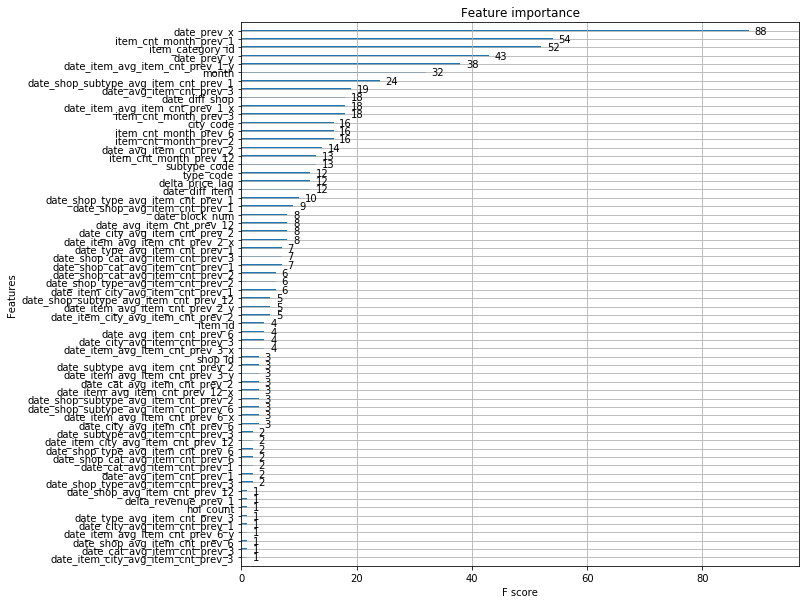

In [27]:
from xgboost import plot_importance
from matplotlib import pyplot
fig, ax = plt.subplots(figsize=(10,10))

plot_importance(model, ax=ax)
pyplot.show()